## A notebook to create a bar graph of CTs inside AS

## Install and import libraries

In [304]:
%%capture 
%pip install pandas seaborn numpy requests matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import requests
from io import StringIO
import textwrap
from pprint import pprint
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import re

In [305]:
# warnings
import warnings
warnings.filterwarnings('ignore')

## Global settings

In [306]:
hra_pop_version = 'v1.0'
branch = 'main'

output_folder = 'output/ctBar3dAs'

## Functions

In [307]:
def move_column_next_to(df, column_to_move, reference_column, after=True):
  """
  Move a column to a position next to a reference column in a DataFrame.

  Args:
      df (pd.DataFrame): The DataFrame in which to reorder columns.
      column_to_move (str): Name of the column to move.
      reference_column (str): Name of the column to position next to.
      after (bool, optional): If True, places `column_to_move` after 
          `reference_column`; if False, places it before. Defaults to True.

  Returns:
      pd.DataFrame: A new DataFrame with reordered columns.
  """
  cols = df.columns.tolist()
  cols.remove(column_to_move)
  ref_index = cols.index(reference_column)
  insert_at = ref_index + 1 if after else ref_index
  cols.insert(insert_at, column_to_move)
  return df[cols]

## Load data

In [308]:
# could also use https://apps.humanatlas.io/api/grlc/hra-pop.html#get-/cell-types-in-atlas
url = f"https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/{branch}/output-data/{hra_pop_version}/reports/atlas-ad-hoc/cell-types-in-anatomical-structurescts-per-as.csv"

headers = {
  'Accept' :'text/csv'
  }

data = requests.get(url=url, headers=headers).text

df = pd.read_csv(StringIO(data))
df

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,1.205,0.147653,3
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,1.182,0.144835,3
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,0.699,0.085651,3
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,0.690,0.084548,3
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,0.540,0.066168,3
...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1
8892,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1
8893,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1
8894,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1


## Preprocess strings

In [309]:
df["organ"] = df["organ"].str.lower()
df["as_label"] = df["as_label"].str.lower()
df["organ"] = df["organ"].replace(
  {
    "right mammary gland": "right breast",
    "left mammary gland": "left breast"
  }
)

## Preprocess using `cell-types-level-mapping.csv`

In [310]:
# walk up CTs
csv_response = requests.get(
    f'https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/{branch}/output-data/{hra_pop_version}/reports/atlas-ad-hoc/cell-types-level-mapping.csv', headers={'accept': 'text/csv'}).text

look_up = pd.read_csv(StringIO(csv_response))

look_up

,cell_label,cell_id,level_1_cell_id,level_1_cell_label,level_2_cell_id,level_2_cell_label
0,cell,http://purl.obolibrary.org/obo/CL_0000000,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
1,hematopoietic stem cell,http://purl.obolibrary.org/obo/CL_0000037,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
2,fibroblast,http://purl.obolibrary.org/obo/CL_0000057,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,http://purl.obolibrary.org/obo/CL_0000499,stromal cell
3,epithelial cell,http://purl.obolibrary.org/obo/CL_0000066,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
4,blood vessel endothelial cell,http://purl.obolibrary.org/obo/CL_0000071,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
...,...,...,...,...,...,...
196,lung migratory dendritic cell,http://purl.obolibrary.org/obo/CL_4033045,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,http://purl.obolibrary.org/obo/CL_0000451,dendritic cell
197,respiratory tract suprabasal cell,http://purl.obolibrary.org/obo/CL_4033048,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
198,cycling macrophage,http://purl.obolibrary.org/obo/CL_4033076,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,http://purl.obolibrary.org/obo/CL_0000235,macrophage
199,cycling alveolar macrophage,http://purl.obolibrary.org/obo/CL_4033077,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,http://purl.obolibrary.org/obo/CL_0000235,macrophage


In [311]:
# df_temp = df_mammary
df_temp = df

In [312]:
# Merge look-up df with df
df_temp = df.merge(
    look_up[['cell_id','level_1_cell_id','level_1_cell_label']],
    left_on='cell_id',  # Column in main df
    right_on='cell_id',  # Column in lookup df
    how='left'      # Keep all rows from main df
)

df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,1.205,0.147653,3,NaN,NaN
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,1.182,0.144835,3,NaN,NaN
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,0.699,0.085651,3,NaN,NaN
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,0.690,0.084548,3,NaN,NaN
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,0.540,0.066168,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1,NaN,NaN


In [313]:
# handle missing values
mask = df_temp['cell_id'].astype(str).str.contains('ASCTB', na=False) == False

df_temp.loc[mask & df_temp['level_1_cell_id'].isna(
), 'level_1_cell_id'] = 'not mapped parent cell'
df_temp.loc[mask & df_temp['level_1_cell_label'].isna(
), 'level_1_cell_label'] = 'not mapped parent cell'

df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,1.205,0.147653,3,NaN,NaN
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,1.182,0.144835,3,NaN,NaN
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,0.699,0.085651,3,NaN,NaN
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,0.690,0.084548,3,NaN,NaN
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,0.540,0.066168,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1,NaN,NaN


## Manually crosswalk unmapped cells

### Download crosswalks and turn them into `df`s

In [314]:
# show unknown cell IDs
# see also https://github.com/x-atlas-consortia/hra-pop/blob/v0.12.0/output-data/v0.12.0/reports/atlas-ad-hoc/unmapped-cell-ids.csv
unmapped = df_temp[df_temp['cell_id'].str.contains(
    'ASCTB')][['organ', 'sex', 'tool', 'cell_label', 'cell_id']].drop_duplicates()
unmapped

,organ,sex,tool,cell_label,cell_id
0,large intestine,Female,celltypist,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte
1,large intestine,Female,celltypist,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell
2,large intestine,Female,celltypist,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial
3,large intestine,Female,celltypist,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t
4,large intestine,Female,celltypist,TA,https://purl.org/ccf/ASCTB-TEMP_ta
...,...,...,...,...,...
8885,lung,Male,sc_proteomics,MPO+,https://purl.org/ccf/ASCTB-TEMP_mpo-
8887,lung,Male,sc_proteomics,CD68+ Macrophage,https://purl.org/ccf/ASCTB-TEMP_cd68-macrophage
8889,lung,Male,sc_proteomics,Smooth Muscle Cell,https://purl.org/ccf/ASCTB-TEMP_smooth-muscle-...
8893,lung,Male,sc_proteomics,Lymphatic Endothelial (and some immune cells),https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...


In [315]:
azimuth = 'https://cdn.humanatlas.io/digital-objects/ctann/azimuth/v1.2/assets/azimuth-crosswalk.csv'
cell_typist = 'https://cdn.humanatlas.io/digital-objects/ctann/celltypist/v1.1/assets/celltypist-crosswalk.csv'
pop_v = 'https://cdn.humanatlas.io/digital-objects/ctann/popv/v1.2/assets/popv-crosswalk.csv'
vccf = 'https://cdn.humanatlas.io/digital-objects/ctann/vccf/v1.0/assets/vccf-crosswalk.csv'

def download_crosswalks(url:str):
  """Download crosswalk and load as df 

  Args:
      url (str): A download URL
      df (pd.DataFrame): Resulting DataFrame
  """
  
  csv_response = requests.get(url).text
  df = pd.read_csv(StringIO(csv_response), skiprows=10)
  return df

In [316]:
df_azimuth = download_crosswalks(azimuth)
df_azimuth.insert(0, 'tool', 'azimuth')
df_azimuth

,tool,Organ_Level,Organ_ID,Annotation_Label,Annotation_Label_ID,CL_Label,CL_ID,CL_Match
0,azimuth,Heart_L2,UBERON:0000948,Adipocyte,AZ:0000001,adipocyte,CL:0000136,skos:exactMatch
1,azimuth,Heart_L2,UBERON:0000948,Arterial Endothelial,AZ:0000002,endothelial cell of artery,CL:1000413,skos:exactMatch
2,azimuth,Heart_L2,UBERON:0000948,Atrial Cardiomyocyte,AZ:0000003,regular atrial cardiac myocyte,CL:0002129,skos:exactMatch
3,azimuth,Heart_L2,UBERON:0000948,B,AZ:0000004,B cell,CL:0000236,skos:exactMatch
4,azimuth,Heart_L2,UBERON:0000948,Capillary Endothelial,AZ:0000005,capillary endothelial cell,CL:0002144,skos:exactMatch
...,...,...,...,...,...,...,...,...
759,azimuth,Kidney,UBERON:0002113,Peritubular Capilary Endothelial,NaN,peritubular capillary endothelial cell,CL:1001033,skos:exactMatch
760,azimuth,Bone_marrow,UBERON:0002371,CD8 Effector_1,NaN,"effector CD8-positive, alpha-beta T cell:1",CL:0001050,skos:narrowMatch
761,azimuth,Bone_marrow,UBERON:0002371,CD8 Effector_2,NaN,"effector CD8-positive, alpha-beta T cell:2",CL:0001050,skos:narrowMatch
762,azimuth,Bone_marrow,UBERON:0002371,CD8 Effector_3,NaN,"effector CD8-positive, alpha-beta T cell:3",CL:0001050,skos:narrowMatch


In [317]:
df_cell_typist = download_crosswalks(cell_typist)
df_cell_typist.insert(0, 'tool', 'celltypist')
df_cell_typist

,tool,Organ_Level,Organ_ID,Annotation_Label,Annotation_Label_ID,CL_Label,CL_ID,CL_Match
0,celltypist,blood_L1,UBERON:0000178,Age-associated B cells,CT:0000001,B cell:age-associated,CL:0000236,skos:narrowMatch
1,celltypist,blood_L1,UBERON:0000178,C1 non-classical monocytes,CT:0000002,non-classical monocyte:C1,CL:0000875,skos:narrowMatch
2,celltypist,blood_L1,UBERON:0000178,CD16+ NK cells,CT:0000003,"CD16-positive, CD56-dim natural killer cell, h...",CL:0000939,skos:exactMatch
3,celltypist,blood_L1,UBERON:0000178,CD16- NK cells,CT:0000004,"CD16-negative, CD56-bright natural killer cell...",CL:0000938,skos:exactMatch
4,celltypist,blood_L1,UBERON:0000178,Classical monocytes,CT:0000005,classical monocyte,CL:0000860,skos:exactMatch
...,...,...,...,...,...,...,...,...
888,celltypist,Small_Intestine,UBERON:0002108,myofibroblast,NaN,myofibroblast cell,CL:0000186,skos:exactMatch
889,celltypist,Small_Intestine,UBERON:0002108,myofibroblast (RSPO2+),NaN,myofibroblast cell:RSPO2+,CL:0000186,skos:narrowMatch
890,celltypist,Small_Intestine,UBERON:0002108,pDC,NaN,plasmacytoid dendritic cell,CL:0000784,skos:exactMatch
891,celltypist,Small_Intestine,UBERON:0002108,venous capillary,NaN,pre-venule capillary cell,CL:4047030,skos:exactMatch


In [318]:
df_pop_v = download_crosswalks(pop_v)
df_pop_v.insert(0, 'tool', 'popv')
df_pop_v

,tool,Organ_Level,Organ_ID,Annotation_Label,Annotation_Label_ID,CL_Label,CL_ID,CL_Match
0,popv,blood,UBERON:0000178,CD141-positive myeloid dendritic cell,PV:0000001,CD141-positive myeloid dendritic cell,CL:0002394,skos:exactMatch
1,popv,blood,UBERON:0000178,"CD4-positive, alpha-beta memory T cell",PV:0000002,"CD4-positive, alpha-beta memory T cell",CL:0000897,skos:exactMatch
2,popv,blood,UBERON:0000178,"CD8-positive, alpha-beta T cell",PV:0000003,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch
3,popv,blood,UBERON:0000178,"CD8-positive, alpha-beta cytokine secreting ef...",PV:0000004,"CD8-positive, alpha-beta cytokine secreting ef...",CL:0000908,skos:exactMatch
4,popv,blood,UBERON:0000178,T cell,PV:0000005,T cell,CL:0000084,skos:exactMatch
...,...,...,...,...,...,...,...,...
442,popv,prostate gland,UBERON:0002367,bronchial epithelial cell,NaN,epithelial cell,CL:0000066,skos:narrowMatch
443,popv,thymus,UBERON:0002370,"CD4-positive, CD25-positive, alpha-beta regula...",NaN,"CD4-positive, CD25-positive, alpha-beta regula...",CL:0000792,skos:exactMatch
444,popv,thymus,UBERON:0002370,"CD4-positive, alpha-beta T cell",NaN,"CD4-positive, alpha-beta T cell",CL:0000624,skos:exactMatch
445,popv,bone marrow,UBERON:0002371,"B cell, CD19-positive",NaN,"B cell, CD19-positive",CL:0001201,skos:exactMatch


In [319]:
df_vccf = download_crosswalks(vccf)
df_vccf.insert(0, 'tool', 'vccf')
df_vccf

,tool,Organ_Level,Organ_ID,Annotation_Label_ID,Annotation_Label,CL_Label,CL_ID,CL_Match
0,vccf,bonemarrow-codex-chop_L1,UBERON:0002371,VCCF:0000001,mesenchymal cell,mesenchymal cell,CL:0008019,skos:exactMatch
1,vccf,bonemarrow-codex-chop_L1,UBERON:0002371,VCCF:0000002,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch
2,vccf,bonemarrow-codex-chop_L1,UBERON:0002371,VCCF:0000003,immune cell,leukocyte,CL:0000738,skos:exactMatch
3,vccf,bonemarrow-codex-chop_L1,UBERON:0002371,VCCF:0000004,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch
4,vccf,bonemarrow-codex-chop_L1,UBERON:0002371,VCCF:0000005,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch
...,...,...,...,...,...,...,...,...
497,vccf,tonsil-codex-stanford_L3,UBERON:0002372,VCCF:0000498,squamous epithelial cell,squamous epithelial cell,CL:0000076,skos:exactMatch
498,vccf,tonsil-codex-stanford_L3,UBERON:0002372,VCCF:0000499,stromal cell,stromal cell,CL:0000499,skos:exactMatch
499,vccf,tonsil-codex-stanford_L3,UBERON:0002372,VCCF:0000500,t cell,T cell,CL:0000084,skos:exactMatch
500,vccf,NaN,NaN,VCCF:0000501,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch


In [320]:
df_crosswalks_combined = pd.concat([df_azimuth, df_cell_typist, df_pop_v, df_vccf])
df_crosswalks_combined

,tool,Organ_Level,Organ_ID,Annotation_Label,Annotation_Label_ID,CL_Label,CL_ID,CL_Match
0,azimuth,Heart_L2,UBERON:0000948,Adipocyte,AZ:0000001,adipocyte,CL:0000136,skos:exactMatch
1,azimuth,Heart_L2,UBERON:0000948,Arterial Endothelial,AZ:0000002,endothelial cell of artery,CL:1000413,skos:exactMatch
2,azimuth,Heart_L2,UBERON:0000948,Atrial Cardiomyocyte,AZ:0000003,regular atrial cardiac myocyte,CL:0002129,skos:exactMatch
3,azimuth,Heart_L2,UBERON:0000948,B,AZ:0000004,B cell,CL:0000236,skos:exactMatch
4,azimuth,Heart_L2,UBERON:0000948,Capillary Endothelial,AZ:0000005,capillary endothelial cell,CL:0002144,skos:exactMatch
...,...,...,...,...,...,...,...,...
497,vccf,tonsil-codex-stanford_L3,UBERON:0002372,squamous epithelial cell,VCCF:0000498,squamous epithelial cell,CL:0000076,skos:exactMatch
498,vccf,tonsil-codex-stanford_L3,UBERON:0002372,stromal cell,VCCF:0000499,stromal cell,CL:0000499,skos:exactMatch
499,vccf,tonsil-codex-stanford_L3,UBERON:0002372,t cell,VCCF:0000500,T cell,CL:0000084,skos:exactMatch
500,vccf,NaN,NaN,endothelial cell,VCCF:0000501,endothelial cell,CL:0000115,skos:exactMatch


### Create `ASCTB-TEMP` codes in crosswalks

In [321]:
# source: https://github.com/hubmapconsortium/hra-workflows/blob/8992e0a6cf67ecc25efa60a84df8bab867adc373/src/util/ids.py#L25
_NON_WORD_REGEX = re.compile(r"\W+")
_NON_ALPHANUM_HYPHEN_REGEX = re.compile(r"[^a-z0-9-]+")
_ASCTB_ID_REGEX = re.compile(r"^ASCTB", re.IGNORECASE)
_ENSEMBL_ID_REGEX = re.compile(r"^ens", re.IGNORECASE)
_VALID_CELL_ID_REGEX = re.compile(r"^(CL|PCL):", re.IGNORECASE)


def create_temp_asctb_id(value: str) -> str:
    """Generate a temporary asctb id from a value.

    Args:
        value (str): The value to create an id for

    Returns:
        str: A temp id
    """
    if _ASCTB_ID_REGEX.match(value):
        return value

    value = value.strip().lower()
    value = re.sub(_NON_WORD_REGEX, "-", value)
    value = re.sub(_NON_ALPHANUM_HYPHEN_REGEX, "", value)
    return f"ASCTB-TEMP:{value}"


def format_temp_asctb_id(id):
  """Takes a ASCTB-TEMP code and turns into a PURL

  Args:
      id (str): An ASCTB-TEMP cide
  """
  
  return f'https://purl.org/ccf/{id.replace(':','_')}'


def create_cell_id(id: str) -> str:
    """Turn an id into a cell id.
    Cell ids start with CL: or PCL: otherwise it is turned into
    a temporary asctb id.

    Args:
        id (str): Original id

    Returns:
        str: Valid cell id
    """
    if _VALID_CELL_ID_REGEX.match(id):
        return id
    return create_temp_asctb_id(id)

In [322]:
df_crosswalks_combined['ASCTB_TEMP_ID'] = df_crosswalks_combined['Annotation_Label'].apply(
    lambda label: format_temp_asctb_id(create_temp_asctb_id(label)))
df_crosswalks_combined

,tool,Organ_Level,Organ_ID,Annotation_Label,Annotation_Label_ID,CL_Label,CL_ID,CL_Match,ASCTB_TEMP_ID
0,azimuth,Heart_L2,UBERON:0000948,Adipocyte,AZ:0000001,adipocyte,CL:0000136,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_adipocyte
1,azimuth,Heart_L2,UBERON:0000948,Arterial Endothelial,AZ:0000002,endothelial cell of artery,CL:1000413,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_arterial-endot...
2,azimuth,Heart_L2,UBERON:0000948,Atrial Cardiomyocyte,AZ:0000003,regular atrial cardiac myocyte,CL:0002129,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_atrial-cardiom...
3,azimuth,Heart_L2,UBERON:0000948,B,AZ:0000004,B cell,CL:0000236,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_b
4,azimuth,Heart_L2,UBERON:0000948,Capillary Endothelial,AZ:0000005,capillary endothelial cell,CL:0002144,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_capillary-endo...
...,...,...,...,...,...,...,...,...,...
497,vccf,tonsil-codex-stanford_L3,UBERON:0002372,squamous epithelial cell,VCCF:0000498,squamous epithelial cell,CL:0000076,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_squamous-epith...
498,vccf,tonsil-codex-stanford_L3,UBERON:0002372,stromal cell,VCCF:0000499,stromal cell,CL:0000499,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_stromal-cell
499,vccf,tonsil-codex-stanford_L3,UBERON:0002372,t cell,VCCF:0000500,T cell,CL:0000084,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_t-cell
500,vccf,NaN,NaN,endothelial cell,VCCF:0000501,endothelial cell,CL:0000115,skos:exactMatch,https://purl.org/ccf/ASCTB-TEMP_endothelial-cell


### Identify rows in `df_temp` with `ASCTB-TEMP` code and save to new `df_mask`

In [323]:
# Filter only rows where cell_id contains 'ASCTB'
mask = df_temp['cell_id'].astype(str).str.contains('ASCTB', na=False)
df_temp_mask = df_temp[mask]
df_temp_mask

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,1.205,0.147653,3,NaN,NaN
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,1.182,0.144835,3,NaN,NaN
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,0.699,0.085651,3,NaN,NaN
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,0.690,0.084548,3,NaN,NaN
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,0.540,0.066168,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8885,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_mpo-,MPO+,93194.724,0.150243,1,NaN,NaN
8887,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_cd68-macrophage,CD68+ Macrophage,43669.620,0.070402,1,NaN,NaN
8889,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_smooth-muscle-...,Smooth Muscle Cell,35655.804,0.057482,1,NaN,NaN
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,NaN,NaN


### Join `df_temp` and `df_crosswalks_combined` by `ASCTB-TEMP` code and get CL ID

In [324]:
# merge only matching rows with df_crosswalks_combined
columns_to_keep = list(dict.fromkeys(
    df_temp_mask.columns.tolist(
    ) + ['Organ_ID', 'tool', 'CL_ID', 'ASCTB_TEMP_ID', 'CL_Label']
))
df_merged = df_temp_mask.merge(
    df_crosswalks_combined,
    left_on=['tool', 'cell_id'],
    right_on=['tool', 'ASCTB_TEMP_ID'],
    how='left'
)[columns_to_keep]

# reorder columns
df_merged = move_column_next_to(df_merged, 'CL_ID', 'cell_id')
df_merged = move_column_next_to(df_merged, 'ASCTB_TEMP_ID', 'cell_id')

# rename columns to make them more verbose
df_merged = df_merged.rename(columns=
  {
    'cell_label':'cell_label_old',
    'cell_id':'cell_id_old',
    'ASCTB_TEMP_ID':'asctb_id_in_crosswalk',
    'CL_ID':'cell_id_crosswalked',
    'CL_Label': 'cell_label_crosswalked'
  }
)

# drop duplicates
df_merged = df_merged.drop_duplicates(
    subset=['tool', 'cell_id_old', 'cell_id_crosswalked'])
df_merged = df_merged[['tool', 'cell_id_old',
                       'cell_label_old', 'asctb_id_in_crosswalk', 'cell_id_crosswalked', 'cell_label_crosswalked']]

df_merged

,tool,cell_id_old,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked
0,celltypist,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte
2,celltypist,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell
4,celltypist,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte
6,celltypist,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell"
8,celltypist,https://purl.org/ccf/ASCTB-TEMP_ta,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell
...,...,...,...,...,...,...
7625,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_mpo-,MPO+,NaN,NaN,NaN
7626,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_cd68-macrophage,CD68+ Macrophage,NaN,NaN,NaN
7627,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_smooth-muscle-...,Smooth Muscle Cell,NaN,NaN,NaN
7628,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN


### Join `df_merged` back with `df_temp`

In [325]:
df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,1.205,0.147653,3,NaN,NaN
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,1.182,0.144835,3,NaN,NaN
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,0.699,0.085651,3,NaN,NaN
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,0.690,0.084548,3,NaN,NaN
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,0.540,0.066168,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1,NaN,NaN


In [326]:
df_merged_dedup = df_merged.drop_duplicates(subset=['tool', 'cell_id_old'])
df_temp = df_temp.merge(
    df_merged_dedup.rename(columns={'cell_id_old': 'cell_id'}),
    on=['tool', 'cell_id'],
    how='left'
)

df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,1.205,0.147653,3,NaN,NaN,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,1.182,0.144835,3,NaN,NaN,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,0.699,0.085651,3,NaN,NaN,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,0.690,0.084548,3,NaN,NaN,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell"
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,0.540,0.066168,3,NaN,NaN,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,NaN,NaN,NaN,NaN
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,NaN,NaN,NaN,NaN
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828,1,NaN,NaN,Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564,1,NaN,NaN,Basal Epithelial Cell,NaN,NaN,NaN


### Reoder columns in `df_temp`

In [327]:
df_temp = move_column_next_to(df_temp, 'cell_label_old', 'cell_label')
df_temp = move_column_next_to(
    df_temp, 'asctb_id_in_crosswalk', 'cell_label_old')
df_temp = move_column_next_to(
    df_temp, 'cell_id_crosswalked', 'asctb_id_in_crosswalk')
df_temp = move_column_next_to(
    df_temp, 'cell_label_crosswalked', 'cell_id_crosswalked')
df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte,1.205,0.147653,3,NaN,NaN
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell,1.182,0.144835,3,NaN,NaN
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte,0.699,0.085651,3,NaN,NaN
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell",0.690,0.084548,3,NaN,NaN
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell,0.540,0.066168,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN,1753.956,0.002828,1,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,Basal Epithelial Cell,NaN,NaN,NaN,970.104,0.001564,1,NaN,NaN


### Run SPARQL query and get `level_1_cell_id` and `level_1_cell_label` for `df_temp`

In [328]:
# load query
with open("scripts/cell-tyoes-level-mapping.rq", "r") as f:
    query = f.read()

# get tuples with manually crosswalked cell IDs and cell labels

filtered = df_temp[['cell_id_crosswalked', 'cell_label_crosswalked']].dropna()

cell_entries = list(zip(filtered['cell_id_crosswalked'],
              filtered['cell_label_crosswalked']))
cell_entries

[('CL:1000347', 'colonocyte'),
 ('CL:0000987', 'IgA plasma cell'),
 ('CL:4030026', 'BEST4+ enterocyte'),
 ('CL:0000896', 'activated CD4-positive, alpha-beta T cell'),
 ('CL:0009010', 'transit amplifying cell'),
 ('CL:0000787', 'memory B cell'),
 ('CL:0000798', 'gamma-delta T cell:TRGV2'),
 ('CL:0000906', 'activated CD8-positive, alpha-beta T cell'),
 ('CL:0000499', 'stromal cell:transitional stromal 3'),
 ('CL:0002038', 'T follicular helper cell'),
 ('CL:0000235', 'macrophage'),
 ('CL:0000160', 'goblet cell:BEST2+'),
 ('CL:0000798', 'gamma-delta T cell:TRGV4'),
 ('CL:0000909', 'CD8-positive, alpha-beta memory T cell'),
 ('CL:0000160', 'goblet cell'),
 ('CL:0000788', 'naive B cell'),
 ('CL:0000815', 'regulatory T cell'),
 ('CL:0000624', 'CD4-positive, alpha-beta T cell:SELL+'),
 ('CL:0000625', 'CD8-positive, alpha-beta T cell:SELL+'),
 ('CL:0000097', 'mast cell'),
 ('CL:0000499', 'stromal cell:2 NPY+'),
 ('CL:0000899', 'T-helper 17 cell'),
 ('CL:4033068', 'cycling B cell'),
 ('CL:000207

In [329]:
# transform into SPARQL-compatible rows
def format_unmapped_cells(entries):
    return "\n".join(f'({id} "{label}")' for id, label in entries)
  
# replace placeholder with formatted rows
formatted_values = format_unmapped_cells(cell_entries)
query = query.replace("#UNMAPPED_CELLS", formatted_values)
pprint(query)

('#+ summary: atlas cell type level mapping\n'
 '\n'
 'PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\n'
 'PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\n'
 'PREFIX owl: <http://www.w3.org/2002/07/owl#>\n'
 'PREFIX CL: <http://purl.obolibrary.org/obo/CL_>\n'
 'PREFIX ccf: <http://purl.org/ccf/>\n'
 'PREFIX HRA: <https://purl.humanatlas.io/collection/hra-api>\n'
 'PREFIX HRApop: <https://purl.humanatlas.io/graph/hra-pop>\n'
 '\n'
 'SELECT ?cell_label ?cell_id\n'
 '  (SAMPLE(?level_1_cell_id) as ?level_1_cell_id) '
 '(SAMPLE(?level_1_cell_label) as ?level_1_cell_label)\n'
 '  (SAMPLE(?level_2_cell_id) as ?level_2_cell_id) '
 '(SAMPLE(?level_2_cell_label) as ?level_2_cell_label)\n'
 'FROM HRA:\n'
 'FROM <https://purl.humanatlas.io/vocab/cl>\n'
 'FROM <https://purl.humanatlas.io/vocab/pcl>\n'
 'WHERE {\n'
 '  VALUES (?cell_id ?cell_label) {\n'
 '\t\t(CL:1000347 "colonocyte")\n'
 '(CL:0000987 "IgA plasma cell")\n'
 '(CL:4030026 "BEST4+ enterocyte")\n'
 '(CL:0000896 "activa

In [330]:
# run query and process results
sparql = "https://lod.humanatlas.io/sparql"

headers = {
    "Accept": "text/csv"
}

response = requests.post(sparql, data={"query": query}, headers=headers)

if response.status_code == 200:
    results = response.json
    df_sparql = pd.read_csv(StringIO(response.text))
else:
    print("Query failed:", response.status_code)
    # print(response.text)

df_sparql

,cell_label,cell_id,level_1_cell_id,level_1_cell_label,level_2_cell_id,level_2_cell_label
0,cell:DZ GC,http://purl.obolibrary.org/obo/CL_0000000,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
1,cell:LZ GC,http://purl.obolibrary.org/obo/CL_0000000,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
2,neuroblast (sensu Vertebrata),http://purl.obolibrary.org/obo/CL_0000031,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
3,stem cell,http://purl.obolibrary.org/obo/CL_0000034,http://purl.obolibrary.org/obo/CL_0000034,stem cell,http://purl.obolibrary.org/obo/CL_0000034,stem cell
4,common lymphoid progenitor,http://purl.obolibrary.org/obo/CL_0000051,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
...,...,...,...,...,...,...
136,immature pericyte,http://purl.obolibrary.org/obo/CL_4047007,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell
137,fetal vein endothelial cell,http://purl.obolibrary.org/obo/CL_4047011,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
138,angiogenic pericyte,http://purl.obolibrary.org/obo/CL_4047012,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell
139,post-arteriole capillary cell,http://purl.obolibrary.org/obo/CL_4047029,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell


### Format CL IDs in `df_sparql` into PURLs

In [331]:
df_sparql['cell_id'] = df_sparql['cell_id'].apply(lambda old_id: old_id.split('/')[-1].replace('_',':'))
df_sparql

,cell_label,cell_id,level_1_cell_id,level_1_cell_label,level_2_cell_id,level_2_cell_label
0,cell:DZ GC,CL:0000000,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
1,cell:LZ GC,CL:0000000,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
2,neuroblast (sensu Vertebrata),CL:0000031,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
3,stem cell,CL:0000034,http://purl.obolibrary.org/obo/CL_0000034,stem cell,http://purl.obolibrary.org/obo/CL_0000034,stem cell
4,common lymphoid progenitor,CL:0000051,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
...,...,...,...,...,...,...
136,immature pericyte,CL:4047007,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell
137,fetal vein endothelial cell,CL:4047011,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
138,angiogenic pericyte,CL:4047012,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell
139,post-arteriole capillary cell,CL:4047029,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell


### Merge `df_sparql` into `df_temp`

In [332]:
df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte,1.205,0.147653,3,NaN,NaN
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell,1.182,0.144835,3,NaN,NaN
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte,0.699,0.085651,3,NaN,NaN
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell",0.690,0.084548,3,NaN,NaN
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell,0.540,0.066168,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN,1753.956,0.002828,1,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,Basal Epithelial Cell,NaN,NaN,NaN,970.104,0.001564,1,NaN,NaN


In [333]:
# Drop duplicates to ensure unique index (keep first match)
id_lookup = df_sparql.drop_duplicates(subset='cell_id').set_index('cell_id')['level_2_cell_id']
label_lookup = df_sparql.drop_duplicates(subset='cell_id').set_index('cell_id')['level_2_cell_label']

# Create the mask for valid rows
mask = df_temp['cell_id_crosswalked'].notna()

# Map safely
df_temp.loc[mask, 'level_1_cell_id'] = df_temp.loc[mask,'cell_id_crosswalked'].map(id_lookup)
df_temp.loc[mask, 'level_1_cell_label'] = df_temp.loc[mask,'cell_id_crosswalked'].map(label_lookup)

df_temp

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte,1.205,0.147653,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell,1.182,0.144835,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte,0.699,0.085651,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell",0.690,0.084548,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell,0.540,0.066168,3,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN,1753.956,0.002828,1,NaN,NaN
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,Basal Epithelial Cell,NaN,NaN,NaN,970.104,0.001564,1,NaN,NaN


## Misc. preprocessing

### Fill in 'not crosswalked'

In [334]:
df_temp[(~df_temp['cell_id'].str.contains('ASCTB'))]

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
112,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002071,enterocyte of epithelium of large intestine,NaN,NaN,NaN,NaN,2.318,0.284034,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
113,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000786,plasma cell,NaN,NaN,NaN,NaN,1.294,0.158559,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
114,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000624,"CD4-positive, alpha-beta T cell",NaN,NaN,NaN,NaN,1.271,0.155741,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
115,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000625,"CD8-positive, alpha-beta T cell",NaN,NaN,NaN,NaN,0.904,0.110771,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
116,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0009009,paneth cell of colon,NaN,NaN,NaN,NaN,0.679,0.083201,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000115,Endothelial,NaN,NaN,NaN,NaN,40223.460,0.064846,1,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
8890,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033038,CD4+ T Cell,NaN,NaN,NaN,NaN,16776.624,0.027046,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell


In [335]:
# # handle missing values
df_temp['level_1_cell_id'] = df_temp['level_1_cell_id'].fillna('not crosswalked')
df_temp['level_1_cell_label'] = df_temp['level_1_cell_label'].fillna('not crosswalked')

In [336]:
df_temp[(~df_temp['cell_id'].str.contains('ASCTB'))& (df_temp['level_1_cell_id'])]

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
112,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002071,enterocyte of epithelium of large intestine,NaN,NaN,NaN,NaN,2.318,0.284034,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
113,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000786,plasma cell,NaN,NaN,NaN,NaN,1.294,0.158559,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
114,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000624,"CD4-positive, alpha-beta T cell",NaN,NaN,NaN,NaN,1.271,0.155741,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
115,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000625,"CD8-positive, alpha-beta T cell",NaN,NaN,NaN,NaN,0.904,0.110771,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
116,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0009009,paneth cell of colon,NaN,NaN,NaN,NaN,0.679,0.083201,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000115,Endothelial,NaN,NaN,NaN,NaN,40223.460,0.064846,1,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
8890,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033038,CD4+ T Cell,NaN,NaN,NaN,NaN,16776.624,0.027046,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell


### Identify CTs that with `not mapped parent cell` and `not crosswalked`

In [337]:
# no mapped parent cell
df_temp[df_temp['level_1_cell_id'].str.contains('not mapped parent cell')]

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
122,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000131,gut endothelial cell,NaN,NaN,NaN,NaN,0.056,0.006862,3,not mapped parent cell,not mapped parent cell
123,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001516,intestinal enteroendocrine cell,NaN,NaN,NaN,NaN,0.034,0.004166,3,not mapped parent cell,not mapped parent cell
322,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000131,gut endothelial cell,NaN,NaN,NaN,NaN,29.743,0.052130,3,not mapped parent cell,not mapped parent cell
332,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1001516,intestinal enteroendocrine cell,NaN,NaN,NaN,NaN,1.470,0.002576,3,not mapped parent cell,not mapped parent cell
353,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000863,M1 Macrophage,NaN,NaN,NaN,NaN,4.459,0.002414,2,not mapped parent cell,not mapped parent cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8807,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,celltypist,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4033080,AT2 proliferating,NaN,NaN,NaN,NaN,4439.099,0.013798,27,not mapped parent cell,not mapped parent cell
8820,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,celltypist,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002480,Goblet (nasal),NaN,NaN,NaN,NaN,1368.738,0.004255,27,not mapped parent cell,not mapped parent cell
8842,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,celltypist,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4033079,Lymphatic EC proliferating,NaN,NaN,NaN,NaN,137.459,0.000427,27,not mapped parent cell,not mapped parent cell
8846,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,celltypist,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4033069,T cells proliferating,NaN,NaN,NaN,NaN,29.280,0.000091,27,not mapped parent cell,not mapped parent cell


In [338]:
# not crosswalked
df_temp[df_temp['level_1_cell_id'].str.contains('not crosswalked')]

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
108,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.001,0.000123,3,not crosswalked,not crosswalked
313,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.049,0.000069,3,not crosswalked,not crosswalked
486,large intestine,http://purl.obolibrary.org/obo/UBERON_0001156,ascending colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.279,0.000060,6,not crosswalked,not crosswalked
653,large intestine,http://purl.obolibrary.org/obo/UBERON_0001157,transverse colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.252,0.000139,3,not crosswalked,not crosswalked
829,large intestine,http://purl.obolibrary.org/obo/UBERON_0001158,descending colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.883,0.000054,4,not crosswalked,not crosswalked
1000,large intestine,http://purl.obolibrary.org/obo/UBERON_0001159,sigmoid colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.062,0.000029,7,not crosswalked,not crosswalked
1200,spleen,http://purl.obolibrary.org/obo/UBERON_0001248,hilum of spleen,Female,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_neutrophils-mo...,Neutrophils/Monocytes,Neutrophils/Monocytes,NaN,NaN,NaN,138.895,0.156258,1,not crosswalked,not crosswalked
1705,skin,http://purl.obolibrary.org/obo/UBERON_0002097,skin,Female,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_ki67,KI67,KI67,NaN,NaN,NaN,819.637,0.161845,3,not crosswalked,not crosswalked
1706,skin,http://purl.obolibrary.org/obo/UBERON_0002097,skin,Female,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_ddb2,DDB2,DDB2,NaN,NaN,NaN,610.309,0.120511,3,not crosswalked,not crosswalked
1707,skin,http://purl.obolibrary.org/obo/UBERON_0002097,skin,Female,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_cd68,CD68,CD68,NaN,NaN,NaN,153.873,0.030384,3,not crosswalked,not crosswalked


In [339]:
df = df_temp

df

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte,1.205,0.147653,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell,1.182,0.144835,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte,0.699,0.085651,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell",0.690,0.084548,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell,0.540,0.066168,3,http://purl.obolibrary.org/obo/CL_0000000,no mapped parent cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN,1753.956,0.002828,1,not crosswalked,not crosswalked
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,Basal Epithelial Cell,NaN,NaN,NaN,970.104,0.001564,1,not crosswalked,not crosswalked


### Update `no mapped parent cell` to `not mapped parent cell`

In [340]:
df_temp.replace('no mapped parent cell',
                'not mapped parent cell', inplace=True)

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,Colonocyte,https://purl.org/ccf/ASCTB-TEMP_colonocyte,CL:1000347,colonocyte,1.205,0.147653,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,IgA plasma cell,IgA plasma cell,https://purl.org/ccf/ASCTB-TEMP_iga-plasma-cell,CL:0000987,IgA plasma cell,1.182,0.144835,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,BEST4+ epithelial,BEST4+ epithelial,https://purl.org/ccf/ASCTB-TEMP_best4-epithelial,CL:4030026,BEST4+ enterocyte,0.699,0.085651,3,http://purl.obolibrary.org/obo/CL_0000066,epithelial cell
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,Activated CD4 T,Activated CD4 T,https://purl.org/ccf/ASCTB-TEMP_activated-cd4-t,CL:0000896,"activated CD4-positive, alpha-beta T cell",0.690,0.084548,3,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_ta,TA,TA,https://purl.org/ccf/ASCTB-TEMP_ta,CL:0009010,transit amplifying cell,0.540,0.066168,3,http://purl.obolibrary.org/obo/CL_0000000,not mapped parent cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_0000097,Mast Cell,NaN,NaN,NaN,NaN,15322.464,0.024702,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8892,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,http://purl.obolibrary.org/obo/CL_4033039,CD8+ T Cell,NaN,NaN,NaN,NaN,3691.176,0.005951,1,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
8893,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),Lymphatic Endothelial (and some immune cells),NaN,NaN,NaN,1753.956,0.002828,1,not crosswalked,not crosswalked
8894,lung,http://purl.org/sig/ont/fma/fma7508,left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,Basal Epithelial Cell,NaN,NaN,NaN,970.104,0.001564,1,not crosswalked,not crosswalked


In [341]:
# filter by tool (azimuth, then celltypist, then popv)
# Function to determine if a row should be kept based on conditions
def filter_rows(df):
    # Step 1: Group by `sex`, `as_label`, and `modality`
    groups = df.groupby(['organ','sex', 'as_label', 'modality'])

    # Step 2: Initialize a list to store the rows to keep
    rows_to_keep = []

    # Step 3: Loop through each group
    for _, group in groups:      
        # If 'azimuth' exists in the group, keep only those rows
        if 'azimuth' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'azimuth'])
        # If no 'azimuth' but 'cell_typist' exists, keep 'cell_typist'
        elif 'celltypist' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'celltypist'])
        # If neither 'azimuth' nor 'cell_typist' exist, keep 'popv'
        elif 'popv' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'popv'])

    # Combine all the rows to keep
    df_filtered = pd.concat(rows_to_keep)
    return df_filtered


# Apply the filtering function
no_proteomics = df[df['tool'] != 'sc_proteomics']
df_filtered = filter_rows(no_proteomics)

# Display the filtered DataFrame
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
1577,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002131,Ventricular Cardiomycoyte,NaN,NaN,NaN,NaN,145434.441,0.431489,28,not mapped parent cell,not mapped parent cell
1578,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000057,Fibroblast,NaN,NaN,NaN,NaN,93014.948,0.275966,28,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell
1579,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000669,Pericyte,NaN,NaN,NaN,NaN,23530.253,0.069812,28,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell
1580,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002144,Capillary Endothelial,NaN,NaN,NaN,NaN,22126.809,0.065648,28,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
1581,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B,NaN,NaN,NaN,NaN,11976.342,0.035533,28,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,NaN,NaN,NaN,NaN,60.768,0.001877,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
5214,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,NaN,NaN,NaN,NaN,47.393,0.001464,4,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell
5215,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,NaN,NaN,NaN,NaN,29.786,0.000920,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell
5216,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,NaN,NaN,NaN,NaN,24.758,0.000765,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell


In [342]:
df_filtered[df_filtered['level_1_cell_label'] == 'not crosswalked']

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label
486,large intestine,http://purl.obolibrary.org/obo/UBERON_0001156,ascending colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.279,0.000060,6,not crosswalked,not crosswalked
313,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.049,0.000069,3,not crosswalked,not crosswalked
829,large intestine,http://purl.obolibrary.org/obo/UBERON_0001158,descending colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.883,0.000054,4,not crosswalked,not crosswalked
108,large intestine,http://purl.obolibrary.org/obo/UBERON_0001052,rectum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.001,0.000123,3,not crosswalked,not crosswalked
1000,large intestine,http://purl.obolibrary.org/obo/UBERON_0001159,sigmoid colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.062,0.000029,7,not crosswalked,not crosswalked
653,large intestine,http://purl.obolibrary.org/obo/UBERON_0001157,transverse colon,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.252,0.000139,3,not crosswalked,not crosswalked
4482,large intestine,http://purl.obolibrary.org/obo/UBERON_0001156,ascending colon,Male,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,1.328,0.000134,8,not crosswalked,not crosswalked
4842,large intestine,http://purl.obolibrary.org/obo/UBERON_0001158,descending colon,Male,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.290,0.000032,7,not crosswalked,not crosswalked
5015,large intestine,http://purl.obolibrary.org/obo/UBERON_0001159,sigmoid colon,Male,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.472,0.000031,8,not crosswalked,not crosswalked
4674,large intestine,http://purl.obolibrary.org/obo/UBERON_0001157,transverse colon,Male,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_-cells-ins-,�� cells (INS+),�� cells (INS+),NaN,NaN,NaN,0.536,0.000062,5,not crosswalked,not crosswalked


## Get counts

In [343]:
# number of cells that are associated with how many cell types that are not covered in existing ontologies (called “not crosswalked” and rendered in black)
df_filtered[df_filtered['level_1_cell_label'] == 'not crosswalked']['cell_count'].sum()

np.float64(8.59)

In [344]:
# number of cells that do not have a mapped parent cell
summary = df_filtered[df_filtered['level_1_cell_label'] == 'not mapped parent cell'].groupby(
    'cell_label')['cell_count'].sum().reset_index()
summary

,cell_label,cell_count
0,AT2 proliferating,530.712
1,Adventitial fibroblasts,13817.642
2,Atrial Cardiomyocyte,21444.213
3,CLDN10+ cells,121.476
4,Cholangiocytes,1054.725
5,DN1 thymic pro-T cell,221.188
6,DN3 thymocyte,416.250
7,DN4 thymocyte,1.273
8,DZ GC cell,279.239
9,Differentiated_KC,2314.064


In [345]:
summary['cell_count'].sum()

np.float64(616987.9589999999)

## Visualize

### Create new labels in the format `{dataset_count}-{organ}-{as_label}` and show at most `n_max` characters

In [346]:
# set max. chars
n_max = 40

# create new labels with organ and as_label so y-axis is sorted and grouped by organ
# df_filtered['organ_as_label'] = (df_filtered['dataset_count'].str + " - " +  df_filtered['organ']+" - "+df_filtered['as_label']).str[:n_max]+'...'
df_filtered['organ_as_label'] = df_filtered[['organ', 'dataset_count', 'as_label']].fillna('').astype(str).agg(' - '.join, axis=1).str[:n_max]+'...'

df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,organ_as_label
1577,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002131,Ventricular Cardiomycoyte,NaN,NaN,NaN,NaN,145434.441,0.431489,28,not mapped parent cell,not mapped parent cell,heart - 28 - heart left ventricle...
1578,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000057,Fibroblast,NaN,NaN,NaN,NaN,93014.948,0.275966,28,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,heart - 28 - heart left ventricle...
1579,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000669,Pericyte,NaN,NaN,NaN,NaN,23530.253,0.069812,28,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,heart - 28 - heart left ventricle...
1580,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002144,Capillary Endothelial,NaN,NaN,NaN,NaN,22126.809,0.065648,28,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,heart - 28 - heart left ventricle...
1581,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B,NaN,NaN,NaN,NaN,11976.342,0.035533,28,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,heart - 28 - heart left ventricle...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,NaN,NaN,NaN,NaN,60.768,0.001877,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,urinary bladder - 4 - trigone of urinary...
5214,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,NaN,NaN,NaN,NaN,47.393,0.001464,4,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,urinary bladder - 4 - trigone of urinary...
5215,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,NaN,NaN,NaN,NaN,29.786,0.000920,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,urinary bladder - 4 - trigone of urinary...
5216,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,NaN,NaN,NaN,NaN,24.758,0.000765,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,urinary bladder - 4 - trigone of urinary...


### Get colors

In [347]:
def create_consistent_color_mapping(df, colors_file_path):
    # Get all unique cell types from the entire dataset
    all_cell_types = df['level_1_cell_label'].unique()

    # Read colors from the text file
    with open(colors_file_path, 'r') as file:
        # Assuming each line in the file contains one color code
        colors = [line.strip() for line in file.readlines()]

    # Create color dictionary
    color_map = {}
    for i, cell_type in enumerate(all_cell_types):
        # Cycle through colors if more than available
        color_idx = i % len(colors)
        color_map[cell_type] = colors[color_idx]
    pprint(color_map)
    return color_map

In [348]:
# Read colors from file
with open('data/colors.txt', 'r') as file:
    colors = [line.strip() for line in file.readlines()]

# Create color mapping using function defined above
color_map = create_consistent_color_mapping(df_filtered, "data/colors.txt")

{'connective tissue cell': '#1f78b4',
 'endothelial cell': '#b2df8a',
 'epithelial cell': '#e31a1c',
 'germ line cell': '#cab2d6',
 'hematopoietic cell': '#33a02c',
 'melanocyte': '#ffff99',
 'muscle cell': '#fb9a99',
 'neural cell': '#fdbf6f',
 'not crosswalked': '#6a3d9a',
 'not mapped parent cell': '#a6cee3',
 'stem cell': '#ff7f00'}


In [349]:
# replace not crosswalked and not mapped parent cell

color_map['not crosswalked'] = '#000000'
color_map['not mapped parent cell'] = '#808080'

### Build visualizations

In [350]:
def wrap_labels(ax, width, axis='y', break_long_words=False):
  """Wraps the labels of the specified axis to a maximum width.

  Args:
      ax (matplotlib.axes.Axes): The axes object.
      width (int): The maximum width of the labels.
      axis (str, optional): The axis to wrap ('x' or 'y'). Defaults to 'y'.
      break_long_words (bool, optional): Whether to break words longer than
                                        the width. Defaults to False.
  """
  if axis == 'y':
      labels = []
      for label in ax.get_yticklabels():
          text = label.get_text()
          labels.append(textwrap.fill(text, width=width,
                        break_long_words=break_long_words))
      ax.set_yticklabels(labels, rotation=0)
  elif axis == 'x':
      labels = []
      for label in ax.get_xticklabels():
            text = label.get_text()
            labels.append(textwrap.fill(text, width=width,
                          break_long_words=break_long_words))
      ax.set_xticklabels(labels, rotation=0)

In [351]:
# Set the figure size globally
sns.set_theme(rc={'figure.figsize': (20, 65)})

In [352]:
def build_stacked_bar_graph(sex: str, df: pd.DataFrame, color_map: dict, swap_labels: bool):
    """Build a stacked horizontal bar graph for a given sex using cell type colors."""

    # Set Seaborn theme and figure size globally
    sns.set_theme(rc={
        'figure.figsize': (15, 65),
        "axes.labelsize": 40,
        "xtick.labelsize": 85,
        "ytick.labelsize": 55
    })

    # Filter data by sex
    df_sex = df[df['sex'] == sex]

    # Group and pivot data
    grouped = df_sex.groupby(['organ_as_label', 'level_1_cell_label'])[
        'cell_percentage'].sum().reset_index()
    pivot_df = grouped.pivot(
        index='organ_as_label', columns='level_1_cell_label', values='cell_percentage').fillna(0)

    # Sort index if needed
    pivot_df.index = pivot_df.index.astype(str)

    # pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.sort_index(key=lambda x: x.str.lower(), ascending=False)

    # Plotting
    fig, ax = plt.subplots()  # Use Seaborn's default figsize set above
    bar_height = 0.3
    y_positions = np.arange(len(pivot_df))
    bottom = np.zeros(len(pivot_df))

    # Stacked horizontal bars
    for col in pivot_df.columns:
        values = pivot_df[col].values
        ax.barh(y_positions, values, left=bottom, height=bar_height,
                label=col, color=color_map.get(col, 'gray'))
        bottom += values

    # Y-axis labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(pivot_df.index)

    # ax.invert_yaxis()

    # X-axis formatting
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

    # Minor ticks and tick marks
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0, 0.25, 0.5, 0.75, 1.0]))
    ax.tick_params(axis='x', which='major', length=10, width=2)
    ax.tick_params(axis='x', which='minor', length=5, width=1, color='gray')

    # Grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Remove legend (or show if needed)
    # ax.legend().remove()

    # Create legend for the main plot
    # main_legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    main_legend = ax.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=False,
        fontsize=35  
    )

    # Also save legend-only version
    fig_legend, ax_legend = plt.subplots(figsize=(8, 6))
    patches = [mpatches.Patch(color=color_map.get(col, 'gray'), label=col) 
              for col in pivot_df.columns]
    ax_legend.legend(handles=patches, loc='center', frameon=True, fontsize=12, ncol=1)
    ax_legend.axis('off')
    fig_legend.patch.set_facecolor('white')
    fig_legend.savefig(f"output/legend_only_{sex}.png", dpi=600, format='png', 
                      bbox_inches='tight', facecolor='white')
    plt.close(fig_legend) 

    # Remove legend (or show if needed)
    ax.legend().remove()

    # Tweak label spacing
    for label in ax.get_yticklabels():
        label.set_linespacing(1)

    # Ensure tick marks are visible
    ax.spines['top'].set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    # White background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    buffer = 0.1  # tiny space below bottom bar
    ax.set_ylim(-0.5 - buffer, len(pivot_df) - 0.5 + bar_height)

    # swap labels and bars if needed
    if swap_labels:
        ax.yaxis.tick_right()       # move y-axis ticks & labels to right side
        # move y-axis label to right
        ax.yaxis.set_label_position("right")
        # After plotting your graph and setting y-ticks and labels
        ax.tick_params(axis='y', length=0)  # hides y-axis tick marks only

    # Uncomment to save
    plt.savefig(f"output/stacked_bar_graph_{sex}.png",dpi=600, format='png', bbox_inches='tight')

    plt.show()
    plt.close()

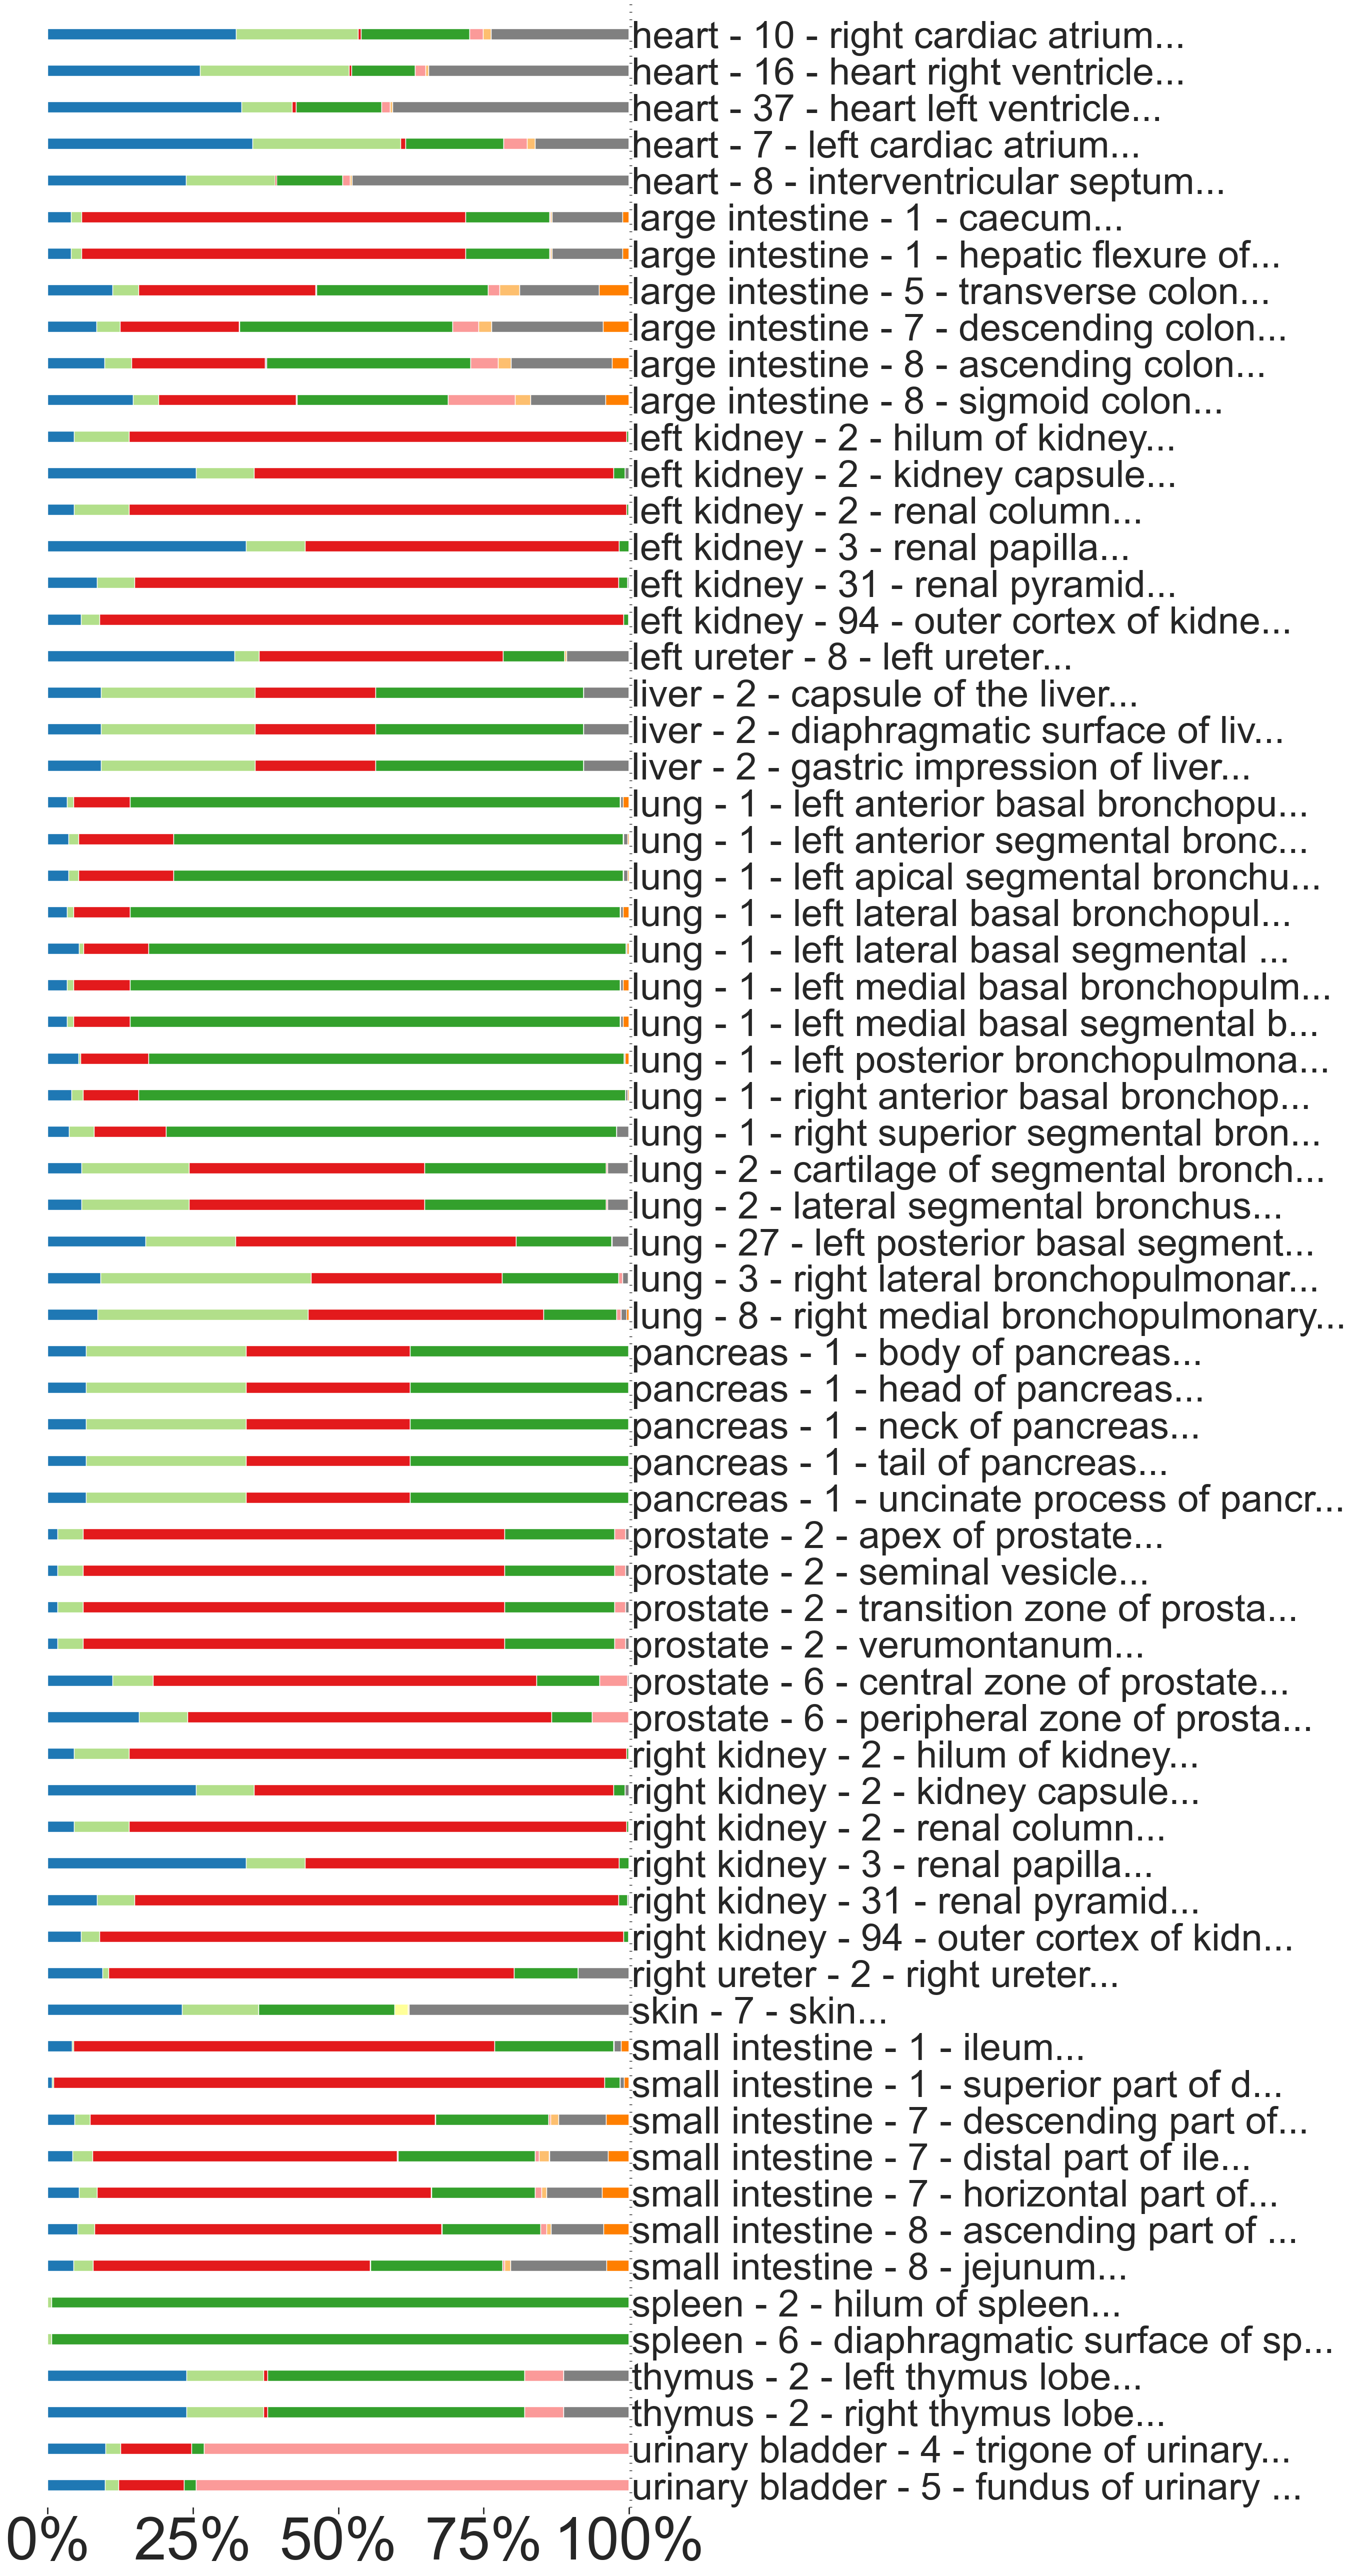

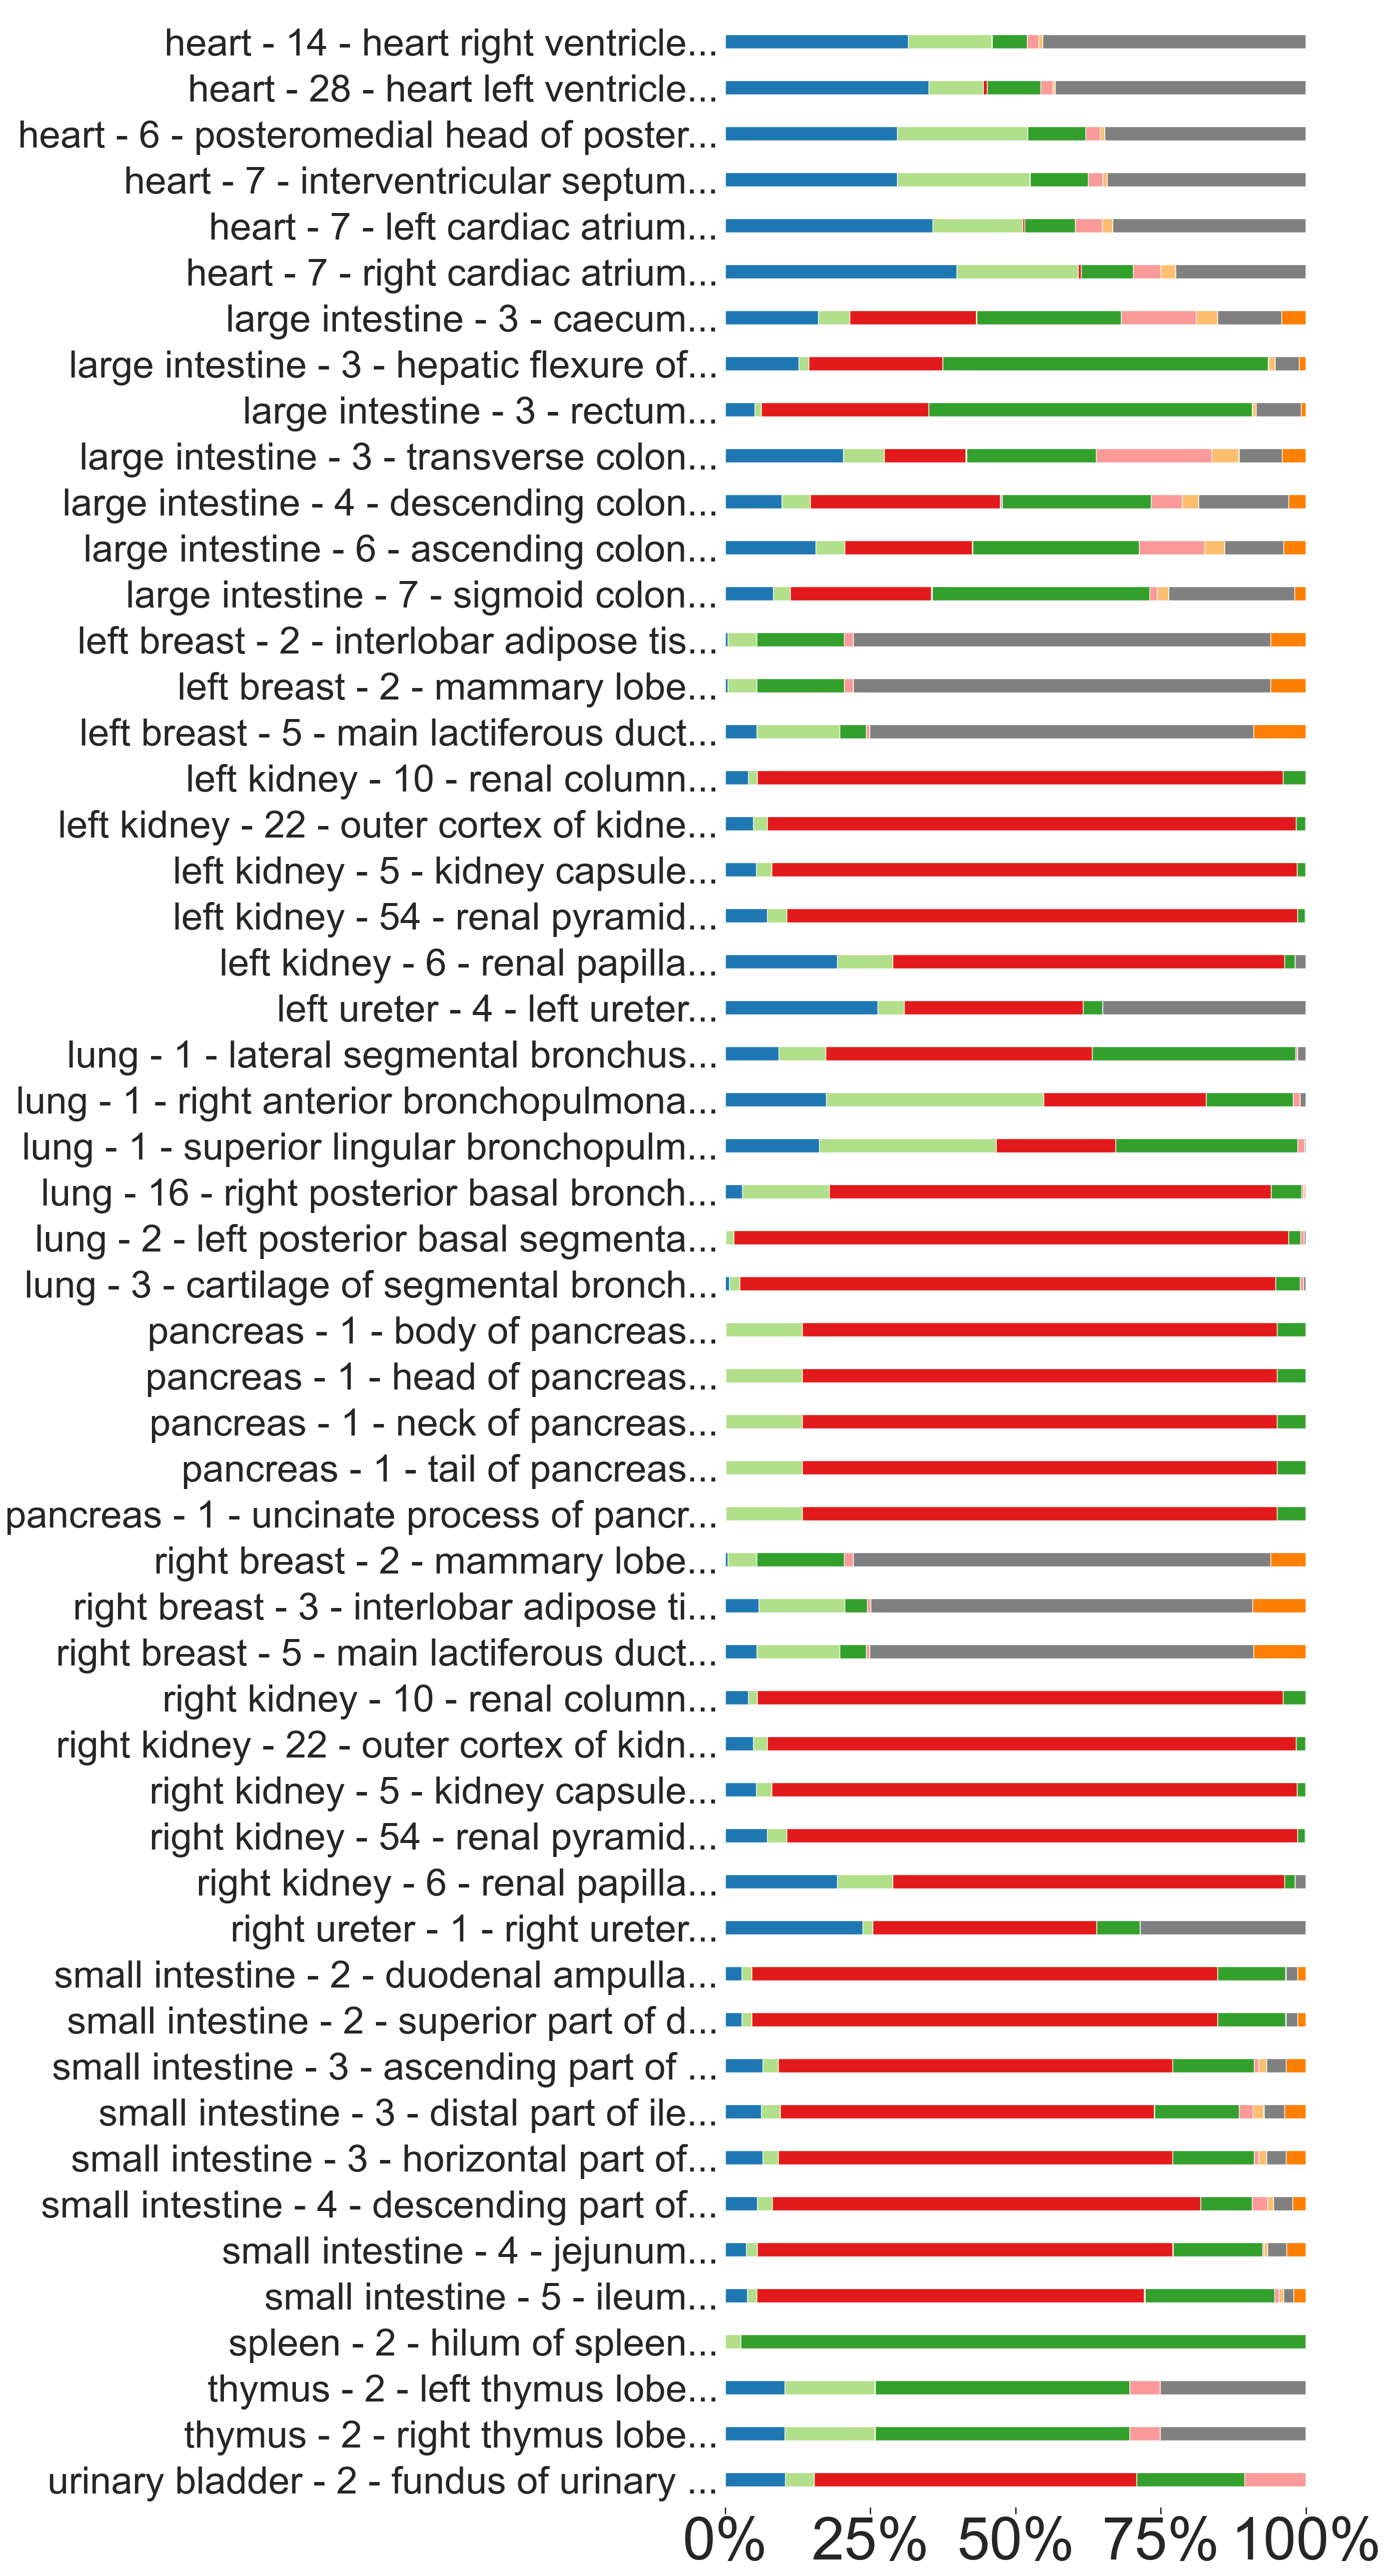

In [353]:
# build visualization
build_stacked_bar_graph('Male', df_filtered, color_map, True)
build_stacked_bar_graph('Female', df_filtered, color_map, False)


## Make look-up for `as_label` to `node_name`

In [354]:
url = 'https://cdn.humanatlas.io/digital-objects/ref-organ/asct-b-3d-models-crosswalk/v1.7/assets/asct-b-3d-models-crosswalk.csv'
df_crosswalk = pd.read_csv(url, skiprows=10)
df_crosswalk

,anatomical_structure_of,source_spatial_entity,node_name,label,OntologyID,representation_of,node_type,glb file of single organs,Ref/1,Ref/1/ID
0,-,#VHFemaleOrgans,VH_F_integumentary_system,integumentary system layer,UBERON:0013754,http://purl.obolibrary.org/obo/UBERON_0013754,organizational,3d-vh-f-united,NaN,NaN
1,#VHFSkinV1.1,#VHFemaleOrgans,VH_F_skin,skin of body,UBERON:0002097,http://purl.obolibrary.org/obo/UBERON_0002097,mesh,3d-vh-f-skin,NaN,NaN
2,-,-,VH_F_mammary_gland,-,-,-,organizational,-,NaN,NaN
3,#VHFLeftMammaryGland,#VHFemaleOrgans,VH_F_mammary_gland_L,Left mammary gland,FMA:57991,http://purl.org/sig/ont/fma/fma57991,organizational,3d-vh-f-mammary-gland-l,NaN,NaN
4,#VHFLeftMammaryGland,#VHFemaleOrgans,VH_F_fat_L,Interlobar adipose tissue of left mammary gland,FMA:73166,http://purl.org/sig/ont/fma/fma73166,mesh,3d-vh-f-mammary-gland-l,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2108,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_1,lumbar vertebra 1,UBERON:0004617,http://purl.obolibrary.org/obo/UBERON_0004617,mesh,VH_M_Vertebrae,NaN,NaN
2109,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_2,lumbar vertebra 2,UBERON:0004618,http://purl.obolibrary.org/obo/UBERON_0004618,mesh,VH_M_Vertebrae,NaN,NaN
2110,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_3,lumbar vertebra 3,UBERON:0004619,http://purl.obolibrary.org/obo/UBERON_0004619,mesh,VH_M_Vertebrae,NaN,NaN
2111,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_4,lumbar vertebra 4,UBERON:0004620,http://purl.obolibrary.org/obo/UBERON_0004620,mesh,VH_M_Vertebrae,NaN,NaN


In [355]:
# only keep relevant rows
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,organ_as_label
1577,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002131,Ventricular Cardiomycoyte,NaN,NaN,NaN,NaN,145434.441,0.431489,28,not mapped parent cell,not mapped parent cell,heart - 28 - heart left ventricle...
1578,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000057,Fibroblast,NaN,NaN,NaN,NaN,93014.948,0.275966,28,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,heart - 28 - heart left ventricle...
1579,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000669,Pericyte,NaN,NaN,NaN,NaN,23530.253,0.069812,28,http://purl.obolibrary.org/obo/CL_0002320,connective tissue cell,heart - 28 - heart left ventricle...
1580,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002144,Capillary Endothelial,NaN,NaN,NaN,NaN,22126.809,0.065648,28,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,heart - 28 - heart left ventricle...
1581,heart,http://purl.obolibrary.org/obo/UBERON_0002084,heart left ventricle,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B,NaN,NaN,NaN,NaN,11976.342,0.035533,28,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,heart - 28 - heart left ventricle...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,NaN,NaN,NaN,NaN,60.768,0.001877,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,urinary bladder - 4 - trigone of urinary...
5214,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,NaN,NaN,NaN,NaN,47.393,0.001464,4,http://purl.obolibrary.org/obo/CL_0000115,endothelial cell,urinary bladder - 4 - trigone of urinary...
5215,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,NaN,NaN,NaN,NaN,29.786,0.000920,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,urinary bladder - 4 - trigone of urinary...
5216,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,NaN,NaN,NaN,NaN,24.758,0.000765,4,http://purl.obolibrary.org/obo/CL_0000988,hematopoietic cell,urinary bladder - 4 - trigone of urinary...


In [356]:
# export relevant columns
subset = df_crosswalk[['label', 'node_name', 'anatomical_structure_of']]
export = subset[subset['label'].isin(df_filtered['as_label'])]
export.to_csv('output/ctBar3dAs/crosswalk.csv', index=False)

## Quality assurance

In [357]:
df_mammary = df_filtered[df_filtered['organ'] == 'Left mammary gland']
df_mammary

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,organ_as_label


In [358]:
df_mammary[df_mammary['level_1_cell_label'].str.contains('not mapped')]

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_label_old,asctb_id_in_crosswalk,cell_id_crosswalked,cell_label_crosswalked,cell_count,cell_percentage,dataset_count,level_1_cell_id,level_1_cell_label,organ_as_label
